## This assignment uses the Leger et al. (2025) manuscript and its accompanying LEIA Python repository to explore the energy and exergy requirements of producing oxygen on the Moon. By working directly with the model code, you’ll see how Python can replicate many of the same capabilities as Aspen—mass balances, energy balances, parameter sweeps, sensitivity analysis, and system‑level performance metrics—without needing a full flowsheet simulator. The goal is not to turn you into a software engineer; the provided scripts already implement the full model, so your work involves running, modifying, and interpreting, not building everything from scratch. This assignment shows how lightweight computational tools can give you deep insight into process efficiency, irreversibility, and lost work in a modern engineering system. 

## Learning goals
- Apply **second‑law** tools to a real engineering system  
- Quantify **energy use**, **exergy destruction**, and **lost work**  
- Explore **parameter sensitivity** in a research‑grade model  
- Build intuition for **energy quality** and **irreversibility** in extreme environments  

Resources:  

D. Leger, F. Ghaffari-Tabrizi, M. Shaw, J. Rasera, D. Dickson, B. Valentin, A. Morlock, F. Thoresen,& A. Cowley, Modeling energy requirements for oxygen production on the Moon, Proc. Natl. Acad. Sci. U.S.A. 122 (8) e2306146122, https://doi.org/10.1073/pnas.2306146122 (2025). 


In [14]:


# importing needed libraries
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib import cm
import seaborn as sns
import math
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# Define colors
colormap = cm.tab20.colors
viridis = cm.get_cmap('viridis', 12)
process_colors = [viridis(0.95), viridis(0.6), viridis(
    0.45), 'red', 'orange', 'grey', viridis(0.2)]


# --- Imports from the repo ---
from modules.beneficiation import Benef_class
from modules.excavation import get_Alpha                  # Alpha (kWh/kg regolith)
from modules.transportation_onlyBeta import get_Beta      # Beta  (kWh/kg regolith/km)
from modules.electrolysis import electrolysis_energy_per_mol_H2O
from modules.hydrogen_reduction import create_rego_heat_list, ilmenite_conversion_percentage
from modules.liquefaction import liquefaction
from modules.Storage import get_Energy_per_kg_LOX

print("✅ Imports successful. Ready to run the baseline.")


/var/folders/yv/jkmvyjh15t98sd6f0h2vbhtr0000gn/T/ipykernel_88084/2001855786.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', 12)


✅ Imports successful. Ready to run the baseline.


In [ ]:
# The following values are copied from the repo to simpfly the code
# ---- baseline inputs (match repo defaults) ----
pre_benef_ilmenite_grade = 0.10
enrichment_factor = 6.0
benef_ilmenite_recovery = 0.505
motor_efficiency = 0.6
mRover = 67
transport_distance_km = 1.0

# Excavation terrain parameters (from calculate_energy.py)
cohCoeff = 1100
intAngle = 45
extAngle = 12.5

# Reactor / thermal defaults (from hydrogen_reduction.py)
batch_reaction_time_in_hours = 2.5
CFI_thickness = 0.06
HTMLI_thickness = 0.06
delta_T_insulation = 200
reactor_heat_up_time_in_hours = 5
T_regolith_in = 273
T_pre_heater = 723

# Electrolysis / cryo / storage defaults (from electrolysis.py and Storage.py)
system_efficiency = 0.6
cryocooler_efficiency = 0.2
T_hot_reservoir_carnot_cycle = 233
T_of_incoming_oxygen = 340

vip_thickness = 0.025
vip_thermal_conductivity = 0.006
vip_emissivity = 0.055
cryocooler_efficiency_storage = 0.2

# Constants
LUNAR_GRAVITY = 1.62
M_ILMENITE = 0.15171   # kg/mol
M_O2 = 0.032           # kg/mol
M_H2 = 0.00201588      # kg/mol
M_H2O = 0.01801528     # kg/mol


In [19]:


# ---- Get energy coefficients ----
rego_exca = get_Alpha(cohCoeff, intAngle, extAngle, motor_efficiency, mRover)  # kWh/kg-regolith (alpha)
rego_tran = get_Beta(motor_efficiency, mRover)                                # kWh/kg-regolith/km (beta)

rego_heat_list = create_rego_heat_list(
    batch_reaction_time_in_hours, CFI_thickness, HTMLI_thickness, delta_T_insulation,
    reactor_heat_up_time_in_hours, T_regolith_in, T_pre_heater
)
water_elec = electrolysis_energy_per_mol_H2O(system_efficiency)               # kWh/mol-water (theta)
dioxy_liq = liquefaction(cryocooler_efficiency, T_hot_reservoir_carnot_cycle, T_of_incoming_oxygen)  # kWh/mol-O2 (psi)
storage_cooling = get_Energy_per_kg_LOX(vip_thickness, vip_thermal_conductivity, vip_emissivity, cryocooler_efficiency_storage)  # kWh/kg-O2

# ---- Mass flow (same chain as calculate_energy.py) ----
X_in_regolith = 1.0  # kg regolith basis
B_in_regolith = X_in_regolith

benef = Benef_class(B_in_regolith, pre_benef_ilmenite_grade, enrichment_factor, benef_ilmenite_recovery)
B_out_ilmenite = benef.B_out_ilmenite
B_out_regolith = benef.B_out_regolith
R_in_regolith = B_out_regolith

ilmenite_conversion = ilmenite_conversion_percentage / 100.0

B_out_ilmenite_mol = B_out_ilmenite / M_ILMENITE
R_out_water_mol = B_out_ilmenite_mol * ilmenite_conversion   # mol H2O produced (and mol H2 consumed)
O2_mol = R_out_water_mol * 0.5
O2_kg_from_1kg_regolith = O2_mol * M_O2                      # kg O2 produced from 1 kg regolith

# ---- Energy accounting (P1–P7) on the 1 kg regolith basis ----
# P1 excavation
P1_X = X_in_regolith * rego_exca

# P2 transport (explicit distance)
P2_T = X_in_regolith * rego_tran * transport_distance_km

# P3 beneficiation handling (repo: lift 1 m + haul tailings distance)
lift_kWh = (B_in_regolith * LUNAR_GRAVITY * 1.0) / 3.6e6  # 1 m lift, ideal
tailings_kg = B_in_regolith - B_out_regolith
haul_kWh = tailings_kg * rego_tran * transport_distance_km
P3_B = lift_kWh + haul_kWh

# P4 reactor heating (repo indexing on post-benef grade)
post_grade_pct = int(round(benef.post_benef_ilmenite_grade * 100))
idx = max(0, min(post_grade_pct * 2 - 1, len(rego_heat_list) - 1))
P4_R = R_in_regolith * rego_heat_list[idx]

# P5 electrolysis
P5_E = R_out_water_mol * water_elec

# P6 liquefaction
P6_L = O2_mol * dioxy_liq

# P7 storage cooling
P7_S = O2_kg_from_1kg_regolith * storage_cooling

# ---- Convert energies to per kg LOX ----
energies_1kg_reg = np.array([P1_X, P2_T, P3_B, P4_R, P5_E, P6_L, P7_S])
process_names = ["P1 Excavation", "P2 Transport", "P3 Beneficiation", "P4 Reactor", "P5 Electrolysis", "P6 Liquefaction", "P7 Storage"]

energies_kWh_per_kg_LOX = energies_1kg_reg / O2_kg_from_1kg_regolith
total_kWh_per_kg_LOX = energies_kWh_per_kg_LOX.sum()

# ---- Mass flows per kg LOX ----
regolith_per_kg_LOX = X_in_regolith / O2_kg_from_1kg_regolith
enriched_regolith_per_kg_LOX = B_out_regolith / O2_kg_from_1kg_regolith
H2_kg_per_kg_LOX = (R_out_water_mol * M_H2) / O2_kg_from_1kg_regolith
H2O_kg_per_kg_LOX = (R_out_water_mol * M_H2O) / O2_kg_from_1kg_regolith

mass_flows = {
    "regolith mass flow [kg/kg LOX]": regolith_per_kg_LOX,
    "enriched_regolith mass flow [kg/kg LOX]": enriched_regolith_per_kg_LOX,
    "H2 circulated [kg/kg LOX]": H2_kg_per_kg_LOX,
    "H2O to electrolysis [kg/kg LOX]": H2O_kg_per_kg_LOX,
    "O2 produced [kg/kg LOX]": 1.0,
}

# ---- Pack results in a neat table ----
df_steps = pd.DataFrame({
    "Process": process_names,
    "Energy_kWh_per_kg_LOX": energies_kWh_per_kg_LOX,
})
df_steps["Share_%"] = 100 * df_steps["Energy_kWh_per_kg_LOX"] / df_steps["Energy_kWh_per_kg_LOX"].sum()

print(f"Total electricity = {total_kWh_per_kg_LOX:.2f} kWh/kg LOX (baseline ~24 kWh/kg LOX)")
display(df_steps.style.format({"Energy_kWh_per_kg_LOX":"{:.3f}", "Share_%":"{:.1f}"}))

print("\nMass flows per kg LOX:")
for k, v in mass_flows.items():
    print(f"  {k}: {v:.3f}")

# Optional: store for later cells (plots / sensitivity / exergy)
baseline_results = {
    "total_kWh_per_kg_LOX": float(total_kWh_per_kg_LOX),
    "steps": df_steps,
    "mass_flows": mass_flows,
    "debug": {
        "O2_kg_from_1kg_regolith": float(O2_kg_from_1kg_regolith),
        "rego_exca": float(rego_exca),
        "rego_tran": float(rego_tran),
        "post_grade_pct": post_grade_pct,
    }
}


Work required to liquefy 1 mol of O2: 0.037399999999999996 [kWh/mol]
Work per kg of O2: 1.16875 [kWh/kg]
ZBO 0.3052809047358302
Total electricity = 24.40 kWh/kg LOX (baseline ~24 kWh/kg LOX)


,Process,Energy_kWh_per_kg_LOX,Share_%
0,P1 Excavation,0.002,0.0
1,P2 Transport,0.144,0.6
2,P3 Beneficiation,0.132,0.5
3,P4 Reactor,13.355,54.7
4,P5 Electrolysis,9.293,38.1
5,P6 Liquefaction,1.169,4.8
6,P7 Storage,0.305,1.3



Mass flows per kg LOX:
  regolith mass flow [kg/kg LOX]: 393.961
  enriched_regolith mass flow [kg/kg LOX]: 33.158
  H2 circulated [kg/kg LOX]: 0.126
  H2O to electrolysis [kg/kg LOX]: 1.126
  O2 produced [kg/kg LOX]: 1.000


## The next section will be used to calculate Exergy and Lost Work

In [ ]:

# Use the baseline_results from the previous cell
E_electric_in = baseline_results["total_kWh_per_kg_LOX"]      # kWh/kg LOX (electricity is ~100% exergy)
mf = baseline_results["mass_flows"]

# ---- Stoichiometric H2 requirement from the model's mol bookkeeping ----
# In your model chain:
#   R_out_water_mol = mol H2O produced in reactor
#   Electrolysis: H2O -> H2 + 0.5 O2
# So per mol O2 produced, 2 mol H2 are involved (net circulated).
#
# We already computed/printed: H2 circulated [kg/kg LOX] in previous cell
m_H2_per_kg_LOX = mf["H2 circulated [kg/kg LOX]"]           # kg H2 / kg LOX

# ---- Exergy proxy (chemical exergy) ----
# Approximate "useful chemical energy" associated with 1 kg LOX as:
#   Ex_O2 ≈ (kg H2 needed per kg O2) * LHV_H2
# This is a proxy for the chemical exergy of the oxidizer relative to fuel availability.
LHV_H2_kWh_per_kg = 39.7                                      # kWh/kg (matches repo convention)
Ex_out = m_H2_per_kg_LOX * LHV_H2_kWh_per_kg                  # kWh/kg LOX

# ---- Lost work + second-law efficiency ----
lost_work = E_electric_in - Ex_out                            # kWh/kg LOX (approx)
eta_2nd = Ex_out / E_electric_in                              # dimensionless

# ---- Report ----
exergy_report = pd.DataFrame({
    "Quantity": [
        "Electricity in (≈ exergy in)",
        "H2 circulated per kg LOX",
        "Product exergy proxy (based on H2 LHV)",
        "Lost work (≈ E_in − Ex_out)",
        "Second-law efficiency (≈ Ex_out / E_in)",
    ],
    "Value": [
        E_electric_in,
        m_H2_per_kg_LOX,
        Ex_out,
        lost_work,
        eta_2nd,
    ],
    "Units": [
        "kWh/kg LOX",
        "kg H2/kg LOX",
        "kWh/kg LOX",
        "kWh/kg LOX",
        "-",
    ]
})

display(exergy_report.style.format({"Value": "{:.4f}"}))

print(f"Electricity in: {E_electric_in:.3f} kWh/kg LOX")
print(f"Exergy out (proxy): {Ex_out:.3f} kWh/kg LOX")
print(f"Lost work: {lost_work:.3f} kWh/kg LOX")
print(f"Second-law efficiency: {eta_2nd:.3f}")


,Quantity,Value,Units
0,Electricity in (≈ exergy in),24.4004,kWh/kg LOX
1,H2 circulated per kg LOX,0.1260,kg H2/kg LOX
2,Product exergy proxy (based on H2 LHV),5.0019,kWh/kg LOX
3,Lost work (≈ E_in − Ex_out),19.3985,kWh/kg LOX
4,Second-law efficiency (≈ Ex_out / E_in),0.2050,-


Electricity in: 24.400 kWh/kg LOX
Exergy out (proxy): 5.002 kWh/kg LOX
Lost work: 19.398 kWh/kg LOX
Second-law efficiency: 0.205


## This section is for sensitivity analysis 

Work required to liquefy 1 mol of O2: 0.037399999999999996 [kWh/mol]
Work per kg of O2: 1.16875 [kWh/kg]
ZBO 0.3052809047358302
Work required to liquefy 1 mol of O2: 0.037399999999999996 [kWh/mol]
Work per kg of O2: 1.16875 [kWh/kg]
ZBO 0.3052809047358302
Work required to liquefy 1 mol of O2: 0.037399999999999996 [kWh/mol]
Work per kg of O2: 1.16875 [kWh/kg]
ZBO 0.3052809047358302
Work required to liquefy 1 mol of O2: 0.037399999999999996 [kWh/mol]
Work per kg of O2: 1.16875 [kWh/kg]
ZBO 0.3052809047358302
Work required to liquefy 1 mol of O2: 0.037399999999999996 [kWh/mol]
Work per kg of O2: 1.16875 [kWh/kg]
ZBO 0.3052809047358302
Work required to liquefy 1 mol of O2: 0.037399999999999996 [kWh/mol]
Work per kg of O2: 1.16875 [kWh/kg]
ZBO 0.3052809047358302
Work required to liquefy 1 mol of O2: 0.037399999999999996 [kWh/mol]
Work per kg of O2: 1.16875 [kWh/kg]
ZBO 0.3052809047358302


,enrichment_factor,total_kWh_per_kg_LOX
0,3.000000,34.108
1,4.166667,28.701
2,5.333333,25.591
3,6.500000,23.654
4,7.666667,22.306
5,8.833333,21.273
6,10.000000,20.576


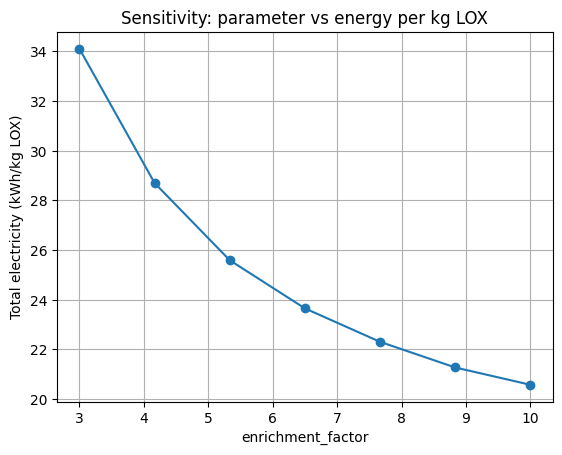

In [ ]:
# TODO: Choose ONE to vary and replace "enrichment_factor"
#   "enrichment_factor"
#   "system_efficiency"          (electrolyzer efficiency)
#   "T_pre_heater"               (hydrogen inlet / pre-heater temperature, K)
#   "insulation_thickness"       (m) -> applied to BOTH CFI_thickness and HTMLI_thickness
#   "batch_reaction_time"        (hours)
param_name  = "enrichment_factor"

# TODO: Choose range + number of steps (use ~5–8 values) spanning the realistic range given in Table 1 of the paper 
#replace the values below
param_start = 3.0
param_stop  = 10.0
n_steps     = 7

values = np.linspace(param_start, param_stop, n_steps)
energies_total = []   # total kWh/kg LOX at each value


for v in values:

    # 1) Start from baseline values (defined in earlier cells)
    EF      = enrichment_factor
    etaE    = system_efficiency
    Tpre    = T_pre_heater
    CFI     = CFI_thickness
    HTMLI   = HTMLI_thickness
    t_batch = batch_reaction_time_in_hours

    # 2) Change ONE parameter (based on param_name)
    if param_name == "enrichment_factor":
        EF = float(v)
    elif param_name == "system_efficiency":
        etaE = float(v)
    elif param_name == "T_pre_heater":
        Tpre = float(v)
    elif param_name == "insulation_thickness":
        CFI = float(v)
        HTMLI = float(v)
    elif param_name == "batch_reaction_time":
        t_batch = float(v)

    # --- Repo energy coefficients ---
    rego_exca = get_Alpha(cohCoeff, intAngle, extAngle, motor_efficiency, mRover)     # kWh/kg-regolith
    rego_tran = get_Beta(motor_efficiency, mRover)                                   # kWh/kg-regolith/km

    rego_heat_list = create_rego_heat_list(
        t_batch, CFI, HTMLI, delta_T_insulation,
        reactor_heat_up_time_in_hours, T_regolith_in, Tpre
    )

    water_elec = electrolysis_energy_per_mol_H2O(etaE)                               # kWh/mol-water
    dioxy_liq  = liquefaction(cryocooler_efficiency, T_hot_reservoir_carnot_cycle, T_of_incoming_oxygen)  # kWh/mol-O2
    storage_cooling = get_Energy_per_kg_LOX(
        vip_thickness, vip_thermal_conductivity, vip_emissivity, cryocooler_efficiency_storage
    )  # kWh/kg-O2

    # --- Mass flow basis: 1 kg regolith ---
    X_in_regolith = 1.0
    B_in_regolith = X_in_regolith

    benef = Benef_class(B_in_regolith, pre_benef_ilmenite_grade, EF, benef_ilmenite_recovery)
    B_out_ilmenite = benef.B_out_ilmenite
    B_out_regolith = benef.B_out_regolith
    R_in_regolith = B_out_regolith

    ilmenite_conversion = ilmenite_conversion_percentage / 100.0
    B_out_ilmenite_mol = B_out_ilmenite / M_ILMENITE
    R_out_water_mol = B_out_ilmenite_mol * ilmenite_conversion
    O2_mol = R_out_water_mol * 0.5
    O2_kg = O2_mol * M_O2

    # --- Energies on 1 kg regolith basis (P1–P7) ---
    P1_X = X_in_regolith * rego_exca
    P2_T = X_in_regolith * rego_tran * transport_distance_km

    lift_kWh = (B_in_regolith * LUNAR_GRAVITY * 1.0) / 3.6e6
    tailings_kg = B_in_regolith - B_out_regolith
    haul_kWh = tailings_kg * rego_tran * transport_distance_km
    P3_B = lift_kWh + haul_kWh

    post_grade_pct = int(round(benef.post_benef_ilmenite_grade * 100))
    idx = max(0, min(post_grade_pct * 2 - 1, len(rego_heat_list) - 1))
    P4_R = R_in_regolith * rego_heat_list[idx]

    P5_E = R_out_water_mol * water_elec
    P6_L = O2_mol * dioxy_liq
    P7_S = O2_kg * storage_cooling

    energies_1kg_reg = np.array([P1_X, P2_T, P3_B, P4_R, P5_E, P6_L, P7_S])
    E_total_kWh_per_kg_LOX = float(energies_1kg_reg.sum() / O2_kg)
    energies_total.append(E_total_kWh_per_kg_LOX)

# --- Report sensitivity results ---

sens_df = pd.DataFrame({param_name: values, "total_kWh_per_kg_LOX": energies_total})
display(sens_df.style.format({"total_kWh_per_kg_LOX": "{:.3f}"}))

plt.figure()
plt.plot(sens_df[param_name], sens_df["total_kWh_per_kg_LOX"], marker="o")
plt.xlabel(param_name)
plt.ylabel("Total electricity (kWh/kg LOX)")
plt.title("Sensitivity: parameter vs energy per kg LOX")
plt.grid(True)
plt.show()


## Optional Challenge (Extra Credit) 

Modify the model to compute exergy destruction per process step using: 

Ėdestroyed = T0𝛥Sgen 

Plot exergy destruction across P1–P7 and compare to energy consumption. 